# Contour detection for probability maps and Fv/Fm images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from scipy import ndimage
import skimage as ski
from skimage import measure
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

In [91]:
threshold = .5
min_contour_size = 100

In [68]:
def resize_padding(image, RGB, h_target, w_target):
    """Adds some padding to an image to correspond to specified height and width

    Args:
        image (ndarray): image name
        RGB (boolean): True if RGB (3 channels), False if greyscale
        h_target (int): wanted number of pixels for height
        w_target (int): wanted number of pixels for width
    
    Returns:
        result (ndarray): padded image
    """

    h, w = image.shape[0:2]
    if h_target < h or w_target < w:
        print("Specified dimensions smaller than the input image")
        return None
        
    delta_h = h_target - h
    delta_w = w_target - w

    pad_up = delta_h//2
    pad_down = h_target - h - pad_up
    pad_left = delta_w//2
    pad_right = w_target - w - pad_left

    if RGB:
        return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                                  cv2.BORDER_CONSTANT, value = [255,255,255])
    return cv2.copyMakeBorder(image, pad_up, pad_down, pad_left, pad_right, 
                              cv2.BORDER_CONSTANT, value = 0)

Let's first try to extract contour with 1 sample:

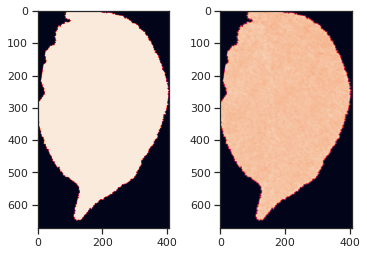

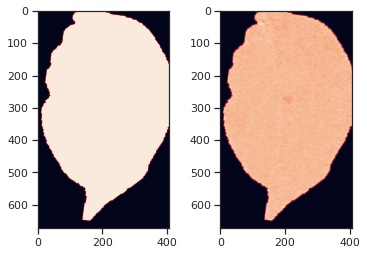

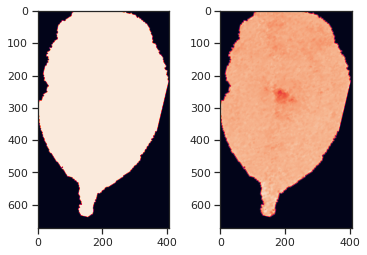

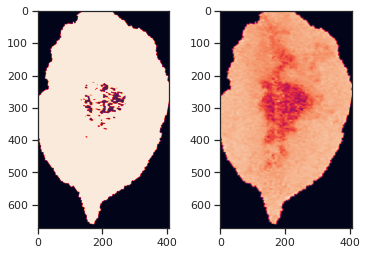

In [114]:
path = '/home/theo/datasets/Dossiers_Mildiou_Maj2023/311_f23_R2_Bintje_ccf_P2'

# A VOIR : /home/theo/Bureau/DATA/Fluo_Visible_Mildiou_Maj2023/Dossiers_Mildiou_Maj2023/203_R1_Desiree_eau_P2

recal_files = ski.io.imread_collection(path + '/Recalibrated_CPD/*').files
segment_RF_files = ski.io.imread_collection(path + '/Segment_RF/*').files                              

fluo_files = []
for file in recal_files:
    if 'FvFm' in file:
        fluo_files.append(file)
fluo_files = sorted(fluo_files, key = str.casefold)

vis_RF_segmented = []
for file in segment_RF_files:
    if 'map' in file:
        vis_RF_segmented.append(file)
vis_RF_segmented = sorted(vis_RF_segmented, key=str.casefold)

l_fluo_threshold = []

for i, fluo_path in enumerate(fluo_files):
    fluo = Image.open(fluo_path)
    proba_map_vis = ski.io.imread(vis_RF_segmented[i])
    fluo_threshold = np.copy(fluo)

    fluo_threshold[(1-fluo_threshold <= threshold)] = 2

    #fluo_threshold[(fluo_threshold >= .6)] = 4
    #fluo_threshold[(fluo_threshold > 0) & (fluo_threshold < .4)] = 1
    #fluo_threshold[(fluo_threshold >= .4) & (fluo_threshold < .5)] = 2
    #fluo_threshold[(fluo_threshold  >= .5) & (fluo_threshold < .6)] = 3
    l_fluo_threshold.append(fluo_threshold)
    plt.subplot(121)
    plt.imshow(fluo_threshold)
    plt.subplot(122)
    plt.imshow(np.array(fluo)*100)
    plt.show()

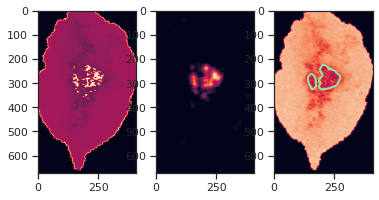

In [93]:
im_fluo = np.array(Image.open(fluo_files[3]))

im_fluo_threshold = np.array(im_fluo)
im_fluo_threshold[(im_fluo_threshold < 1-threshold) & (im_fluo_threshold !=0)] = 2

#Extract mask corresponding to lesion
mask = np.array(im_fluo_threshold)
mask[mask != 0] = 1
kernel = np.ones((10, 10), np.uint8)
mask = cv2.erode(mask, kernel)
im_fluo_2 = np.array(im_fluo_threshold)
im_fluo_2[mask == 0] = 0
im_fluo_2[im_fluo_threshold < 2] = 0

im_fluo_2 = ndimage.maximum_filter(im_fluo_2, size=2)
im_fluo_2 = ndimage.uniform_filter(im_fluo_2, size  = 20)

contours_fluo = measure.find_contours(im_fluo_2, .5)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im_fluo_threshold)
ax2.imshow(im_fluo_2)
ax3.imshow(np.array(im_fluo))
for contour in contours_fluo:
   if len(contour) > min_contour_size:
      ax3.plot(contour[:, 1], contour[:, 0], linewidth=2, color = 'g')
plt.show()

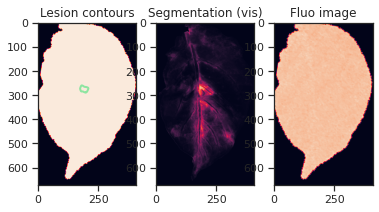

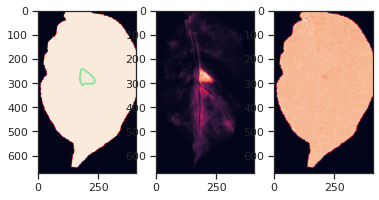

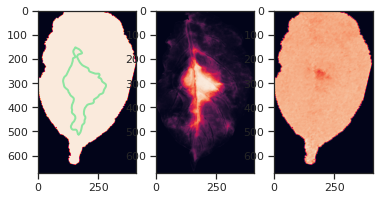

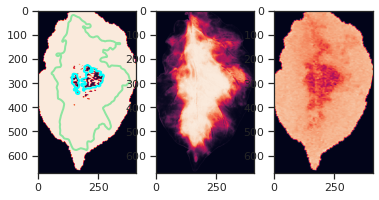

In [94]:
for i, im_segmented in enumerate(vis_RF_segmented):  

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(l_fluo_threshold[i])

    ####################### VISIBLE CONTOUR PART  ############################################

    im_cont = ski.io.imread(im_segmented)
    result_vis = ndimage.maximum_filter(im_cont, size=8)
    result_vis = ndimage.uniform_filter(result_vis, size  = 10)

    contours_vis = measure.find_contours(resize_padding(
                                        result_vis, False, result_vis.shape[0]+2, result_vis.shape[1] + 2), 
                                        threshold) 

    for contour in contours_vis:
        if len(contour) > min_contour_size:
            ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, color = 'g')


    ################ FLUO CONTOUR PART #####################################################
    im_fluo = np.array(Image.open(fluo_files[i]))
    im_fluo_threshold = np.array(im_fluo)
    im_fluo_threshold[(im_fluo_threshold < (1 -threshold)) & (im_fluo_threshold !=0)] = 2

    #Extract mask corresponding to lesion
    mask = np.array(im_fluo_threshold)
    mask[mask != 0] = 1
    kernel = np.ones((10, 10), np.uint8)
    mask = cv2.erode(mask, kernel)
    im_fluo_2 = np.array(im_fluo_threshold)
    im_fluo_2[mask == 0] = 0
    im_fluo_2[im_fluo_threshold < 2] = 0
    im_fluo_2 = ndimage.maximum_filter(im_fluo_2, size=2)
    im_fluo_2 = ndimage.uniform_filter(im_fluo_2, size  = 10)

    contours_fluo = measure.find_contours(im_fluo_2, threshold)

    for contour in contours_fluo:
        if len(contour) > min_contour_size:
            ax1.plot(contour[:, 1], contour[:, 0], linewidth=2, color = 'cyan')

    ax2.imshow(im_cont)
    ax3.imshow(im_fluo)

    if i == 0:
        ax1.set_title('Lesion contours')
        ax2.set_title('Segmentation (vis)')
        ax3.set_title('Fluo image')


### Extraction of areas for the whole dataset

What if we compare the mean areas of contour we got from Fv/Fm images and from segmentation probability maps ?

In [95]:
def infected_area(leaf, threshold, min_contour_size, vis = True):
    """Detects contour for a given threshold, and gives its area.

    Args:
        leaf (2D array): fluo image or probability map.
        threshold (float): value along whitch to find contour.
        vis (bool, optional): True if leaf is a probability map (default). False if leaf is Fv/Fm values.

    Returns:
        int: area of the detected contour.
    """

    if vis:
        result_vis = ndimage.maximum_filter(leaf, size=8)
        result_vis = ndimage.uniform_filter(result_vis, size  = 20)
        contours_vis = measure.find_contours(resize_padding(result_vis, False, 
                                                            result_vis.shape[0]+2,
                                                            result_vis.shape[1] + 2),
                                                            threshold)

        area = 0
        for contour in contours_vis:
            if len(contour) > min_contour_size:
                rr, cc = ski.draw.polygon(contour[:,0], contour[:,1])
                area += len(rr)
        return area

    im_fluo_threshold = np.array(leaf)
    im_fluo_threshold[(im_fluo_threshold < 1 - threshold) & (im_fluo_threshold !=0)] = 2

    mask = np.array(im_fluo_threshold)
    mask[mask != 0] = 1
    kernel = np.ones((10, 10), np.uint8)
    mask = cv2.erode(mask, kernel)
    im_fluo_2 = np.array(im_fluo_threshold)
    im_fluo_2[mask == 0] = 0
    im_fluo_2[im_fluo_threshold < 2] = 0
    im_fluo_2 = ndimage.maximum_filter(im_fluo_2, size=2)
    im_fluo_2 = ndimage.uniform_filter(im_fluo_2, size  = 10)

    contours_fluo = measure.find_contours(im_fluo_2, .5)

    area = 0
    for contour in contours_fluo:
        if len(contour) > min_contour_size:
            rr, cc = ski.draw.polygon(contour[:,0], contour[:,1])
            area += len(rr)
    return area    

Let's use this function on the whole dataset:

In [96]:
folders = ski.io.imread_collection('/home/theo/datasets/Dossiers_Mildiou_Maj2023/*').files

# We don't want to keep leaves treated with water only (no infection):
toremove = []
for f in range(len(folders)):
    if folders[f].endswith('eau'):
        toremove.append(f)
for index in sorted(toremove, reverse=True):
    del folders[index]

areas = np.full([len(folders), 4, 4], np.nan)

for i, fold in enumerate(folders):
    fluo_files = ski.io.imread_collection(fold + '/Recalibrated_CPD/*').files
    segment_RF_files = ski.io.imread_collection(fold + '/Segment_RF/*').files
    segment_XGB_files = ski.io.imread_collection(fold + '/Segment_XGB/*').files
    segment_Unet_files = ski.io.imread_collection(fold + '/Segment_Unet/*').files

    for l in [fluo_files, segment_RF_files, segment_XGB_files, segment_Unet_files]:
        l.sort(key = str.lower)

    day = 0
    for file in fluo_files:
        if 'FvFm' in file:
            img = ski.io.imread(file)
            areas[i, day, 0] = infected_area(img, threshold, min_contour_size, vis = False)
            day += 1
    day  = 0
    for file in segment_RF_files:
        if 'P_map_' in file:
            img = ski.io.imread(file)
            areas[i, day, 1] = infected_area(img, threshold, min_contour_size)
            day += 1
    day = 0
    for file in segment_XGB_files:
        if 'P_map_' in file:
            img = ski.io.imread(file)
            areas[i, day, 2] = infected_area(img, threshold, min_contour_size)
            day += 1
    for day, file in enumerate(segment_Unet_files):  #no need to store days, we only have probability maps files in segment_Unet_files
        img = ski.io.imread(file)
        areas[i, day, 3] = infected_area(img, threshold, min_contour_size)

In [97]:
print("Mean area of lesion for fluo images :",
      round(np.nansum(areas[:,:,0])/areas[:,:,0].size), 'pixels')
print("Mean area of lesion for RF probability maps :", 
      round(np.nansum(areas[:,:,1])/areas[:,:,1].size), 'pixels')
print("Mean area of lesion for XGBoost probability maps :", 
      round(np.nansum(areas[:,:,2])/areas[:,:,2].size), 'pixels')
print("Mean area of lesion for Unet probability maps :", 
      round(np.nansum(areas[:,:,3])/areas[:,:,3].size), 'pixels')

Mean area of lesion for fluo images : 7686 pixels
Mean area of lesion for RF probability maps : 42615 pixels
Mean area of lesion for XGBoost probability maps : 51131 pixels
Mean area of lesion for Unet probability maps : 41951 pixels


Now let's take a look at the data we just gathered. Boxplots will give us an overview, but further statistical analysis using R will be done later.

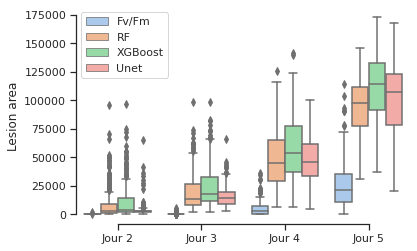

In [98]:
x_names = ['Jour 2', 'Jour 3', 'Jour 4', 'Jour 5']
hue_names = ['Fv/Fm', 'RF', 'XGBoost', 'Unet']
dim1, dim2, dim3 = np.meshgrid(np.arange(areas.shape[0]), x_names, hue_names, indexing='ij')
bp = sns.boxplot(x=dim2.ravel(), y=areas.ravel(), hue=dim3.ravel())
bp.set(ylabel='Lesion area')
sns.despine(trim = True)
plt.show()

Seems like the lesions look much bigger in visible than they are according to Fv/Fm.

In [99]:
tab = pd.DataFrame(zip(areas.ravel(), dim2.ravel(), dim3.ravel()), columns = ['area', 'day', 'modality'])
tab.head()

,area,day,modality
0,0.0,Jour 2,Fv/Fm
1,1541.0,Jour 2,RF
2,1714.0,Jour 2,XGBoost
3,1853.0,Jour 2,Unet
4,1363.0,Jour 3,Fv/Fm


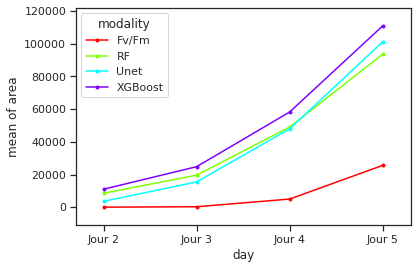

In [100]:
fig = interaction_plot(x = tab['day'], trace = tab['modality'], response = tab['area'])
plt.show()

### Does CFF impacts lesion growth ?

For each leaf, let's extract information about CCF treatment. We want a 1-dimensional array where each row is a leaf, that contains binary data saying if ccf was applied or not.

In [101]:
ccf_list = ['Eau uniquement']*len(folders)

for i, folder in enumerate(folders) :
    if 'ccf' in folder:
        ccf_list[i] = 'Traitement CCF'

Now that we have it, we want to add this information to our 'tab' dataframe

In [102]:
ccf_tab = []
indice = 0
for i in range(len(tab)-1):
    ccf_tab.append(ccf_list[indice])
    if tab['day'][i+1] == 'Jour 2' and tab['day'][i] != 'Jour 2':
        indice += 1
ccf_tab.append(ccf_list[-1])

tab['CCF'] = ccf_tab
tab.head()

,area,day,modality,CCF
0,0.0,Jour 2,Fv/Fm,Traitement CCF
1,1541.0,Jour 2,RF,Traitement CCF
2,1714.0,Jour 2,XGBoost,Traitement CCF
3,1853.0,Jour 2,Unet,Traitement CCF
4,1363.0,Jour 3,Fv/Fm,Traitement CCF


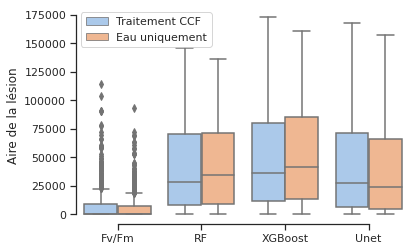

In [103]:
bp = sns.boxplot(x = tab['modality'], y = tab['area'], hue = tab['CCF'])
bp.set(xlabel=None, ylabel='Aire de la lésion')
bp.set_xticklabels(['Fv/Fm', 'RF', 'XGBoost', 'Unet'])
bp.legend_.set_title(None)
sns.despine(trim = True)
plt.show()

### Impact of variety on lesion size

In [104]:
variety_list = ['']*len(folders)

for i, folder in enumerate(folders):
    if '_Bintje_' in folder:
        variety_list[i] = 'Bintje'
    elif '_Desiree_' in folder:
        variety_list[i] = 'Desiree'
    elif '_Bf15_' in folder:
        variety_list[i] = 'Bf15'
    elif '_Rosa_' in folder:
        variety_list[i] = 'Rosa'

In [105]:
variety_tab = []
indice = 0
for i in range(len(tab)-1):
    variety_tab.append(variety_list[indice])
    if tab['day'][i+1] == 'Jour 2' and tab['day'][i] != 'Jour 2':
        indice += 1
variety_tab.append(variety_list[-1])

tab['Variety'] = variety_tab
tab.head()

,area,day,modality,CCF,Variety
0,0.0,Jour 2,Fv/Fm,Traitement CCF,Bintje
1,1541.0,Jour 2,RF,Traitement CCF,Bintje
2,1714.0,Jour 2,XGBoost,Traitement CCF,Bintje
3,1853.0,Jour 2,Unet,Traitement CCF,Bintje
4,1363.0,Jour 3,Fv/Fm,Traitement CCF,Bintje


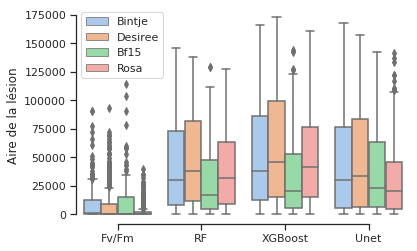

In [106]:
bp = sns.boxplot(x = tab['modality'], y = tab['area'], hue = tab['Variety'])
bp.set(xlabel=None, ylabel='Aire de la lésion')
#bp.set_xticklabels(['Fv/Fm', 'Visible'])
bp.legend_.set_title(None)
sns.despine(trim = True)
plt.show()

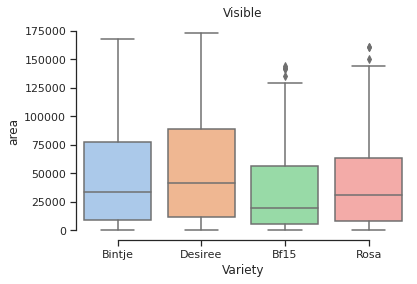

In [107]:
sns.boxplot(x = tab[tab['modality'] != 'Fv/Fm']['Variety'], y = tab[tab['modality'] != 'Fv/Fm']['area']).set(title = 'Visible')
sns.despine(trim = True)

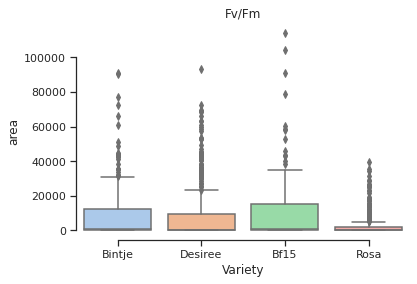

In [108]:
sns.boxplot(x = tab[tab['modality'] == 'Fv/Fm']['Variety'], y = tab[tab['modality'] == 'Fv/Fm']['area']).set(title = 'Fv/Fm')
sns.despine(trim = True)

### What is the impact of phytophtora strain ?

In [109]:
strain_list = ['P1']*len(folders)

for i, folder in enumerate(folders) :
    if '_P2' in folder:
        strain_list[i] = 'P2'

In [110]:
strain_tab = []
indice = 0
for i in range(len(tab)-1):
    strain_tab.append(strain_list[indice])
    if tab['day'][i+1] == 'Jour 2' and tab['day'][i] != 'Jour 2':
        indice += 1
strain_tab.append(strain_list[-1])

tab['Strain'] = strain_tab
tab.head()

,area,day,modality,CCF,Variety,Strain
0,0.0,Jour 2,Fv/Fm,Traitement CCF,Bintje,P1
1,1541.0,Jour 2,RF,Traitement CCF,Bintje,P1
2,1714.0,Jour 2,XGBoost,Traitement CCF,Bintje,P1
3,1853.0,Jour 2,Unet,Traitement CCF,Bintje,P1
4,1363.0,Jour 3,Fv/Fm,Traitement CCF,Bintje,P1


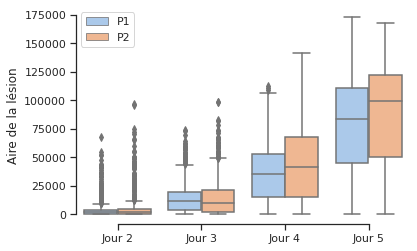

In [111]:
bp = sns.boxplot(x = tab['day'], y = tab['area'], hue = tab['Strain'])
bp.set(xlabel=None, ylabel='Aire de la lésion')
#bp.set_xticklabels(['Fv/Fm', 'Visible'])
bp.legend_.set_title(None)
sns.despine(trim = True)
plt.show()

<AxesSubplot: xlabel='Strain', ylabel='area'>

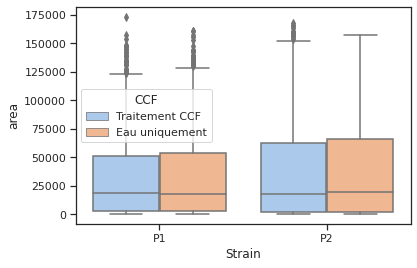

In [112]:
sns.boxplot(x = tab["Strain"], y = tab['area'], hue = tab['CCF'])

In [113]:
tab.to_csv('/home/theo/Bureau/tab_0,5.csv')